In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os, random, torch, time, copy
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from PIL import Image, ImageOps, ImageFilter
from skimage.filters import threshold_local
from time import perf_counter

from torch.autograd import Variable

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# dataset_path = './dataset'
covid_dataset_path = "/content/gdrive/My Drive/archive"

In [ ]:
classes = ['no-covid', 'covid']


In [ ]:
class image_dataset(Dataset):
    """Class creator for the x-ray dataset."""

    def __init__(self, csv_path, root_dir, transform=None, phase=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        # If not a PA view, drop the line 
        self.df.drop(self.df[self.df.view != 'PA'].index, inplace=True)
        self.phase = phase

    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.df['finding'].iloc[idx] != 'COVID-19':
            finding = 0
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}
            
            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        else:
            finding = 1
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}

            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        return sample

In [ ]:
xray_dataset = image_dataset(csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']), root_dir=covid_dataset_path)

In [ ]:
class HistEqualization(object):
    """Image pre-processing.

    Equalize the image historgram
    """
    
    def __call__(self,image):
        
        return ImageOps.equalize(image, mask = None) 

In [ ]:
class ContrastBrightness(object):
    """Image pre-processing.

    alpha = 1.0 # Simple contrast control [1.0-3.0]
    beta = 0    # Simple brightness control [0-100]
    """
    
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def __call__(self,image,):
        image = np.array(image)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y,x] = np.clip(self.alpha*image[y,x] + self.beta, 0, 255)

                return Image.fromarray(np.uint8(image)*255)

In [ ]:
class SmothImage(object):
    """Image pre-processing.

    Smooth the image
    """
    def __call__(self,image):
        
        return image.filter(ImageFilter.SMOOTH_MORE)


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(1),
        transforms.RandomRotation(30, fill=(0,)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        ContrastBrightness(1.2,25),
        HistEqualization(),
        SmothImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],
                             [0.25])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(240),
        transforms.CenterCrop(224),
        ContrastBrightness(1.2,25),
        HistEqualization(),
        SmothImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],
                             [0.25])
    ]),
}

<ipython-input-12-a4c956623ede>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(Nr, Nc, i+1, aspect='auto')


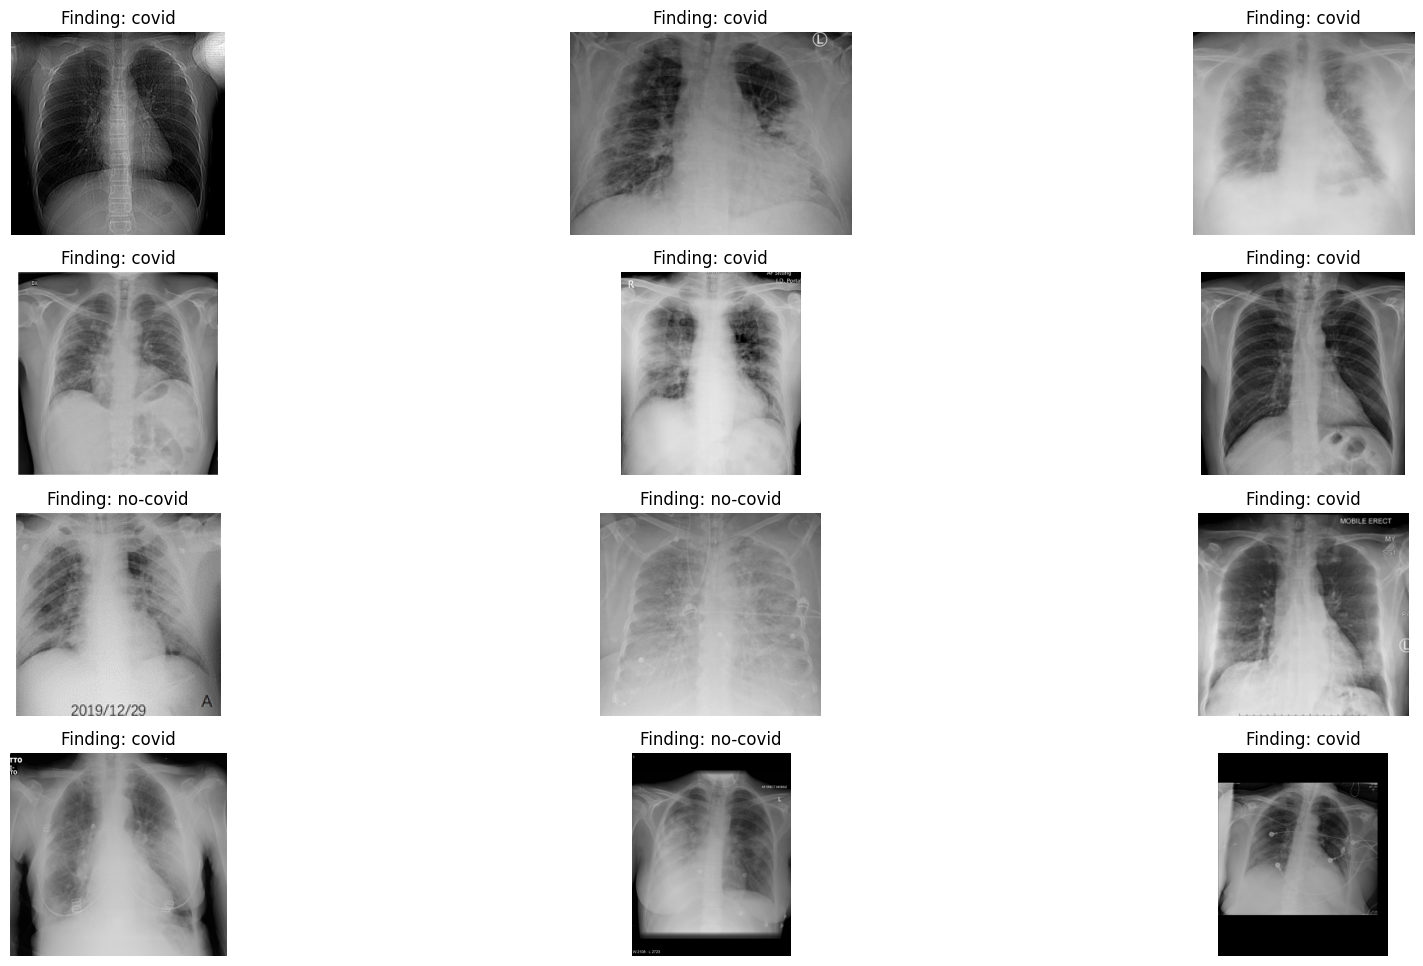

In [ ]:
Nr = 4
Nc = 3

fig, axs = plt.subplots(Nr, Nc,figsize=(20,10))
for i in range(Nr*Nc):
    sample = xray_dataset[
        i + random.randrange(
            0, len(xray_dataset)-(Nr*Nc)
        )]
    
    plt.subplot(Nr, Nc, i+1, aspect='auto')
    plt.tight_layout()
    plt.title('Finding: '+classes[sample['finding']])
    plt.axis('off')
    plt.imshow(sample['image'], cmap='gray')

plt.show()


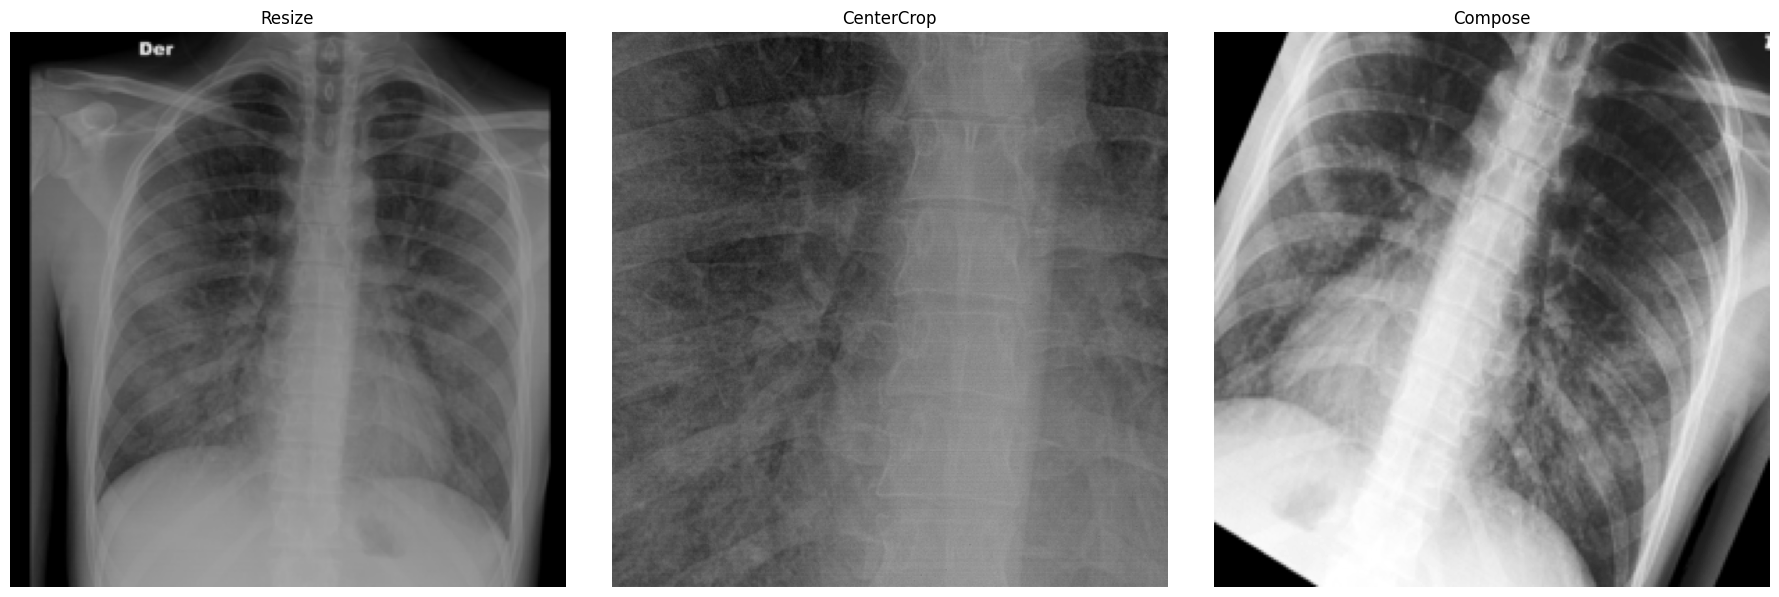

In [ ]:
scale = transforms.Resize(256)
crop = transforms.CenterCrop(400)
composed = transforms.Compose([
    transforms.Grayscale(1),
    HistEqualization(),
    transforms.RandomRotation(30, fill=(0,)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),    
])

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(18, 12))
sample = xray_dataset[random.randrange(0, len(xray_dataset))]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample['image'])

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    plt.axis('off')
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample, cmap='gray')

plt.show()

In [ ]:
xray_transform = image_dataset(
    csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
    root_dir=covid_dataset_path,
    transform=data_transforms,
    phase='train'
)

<ipython-input-15-d3e031a38144>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(Nr, Nc, i+1, aspect='auto')


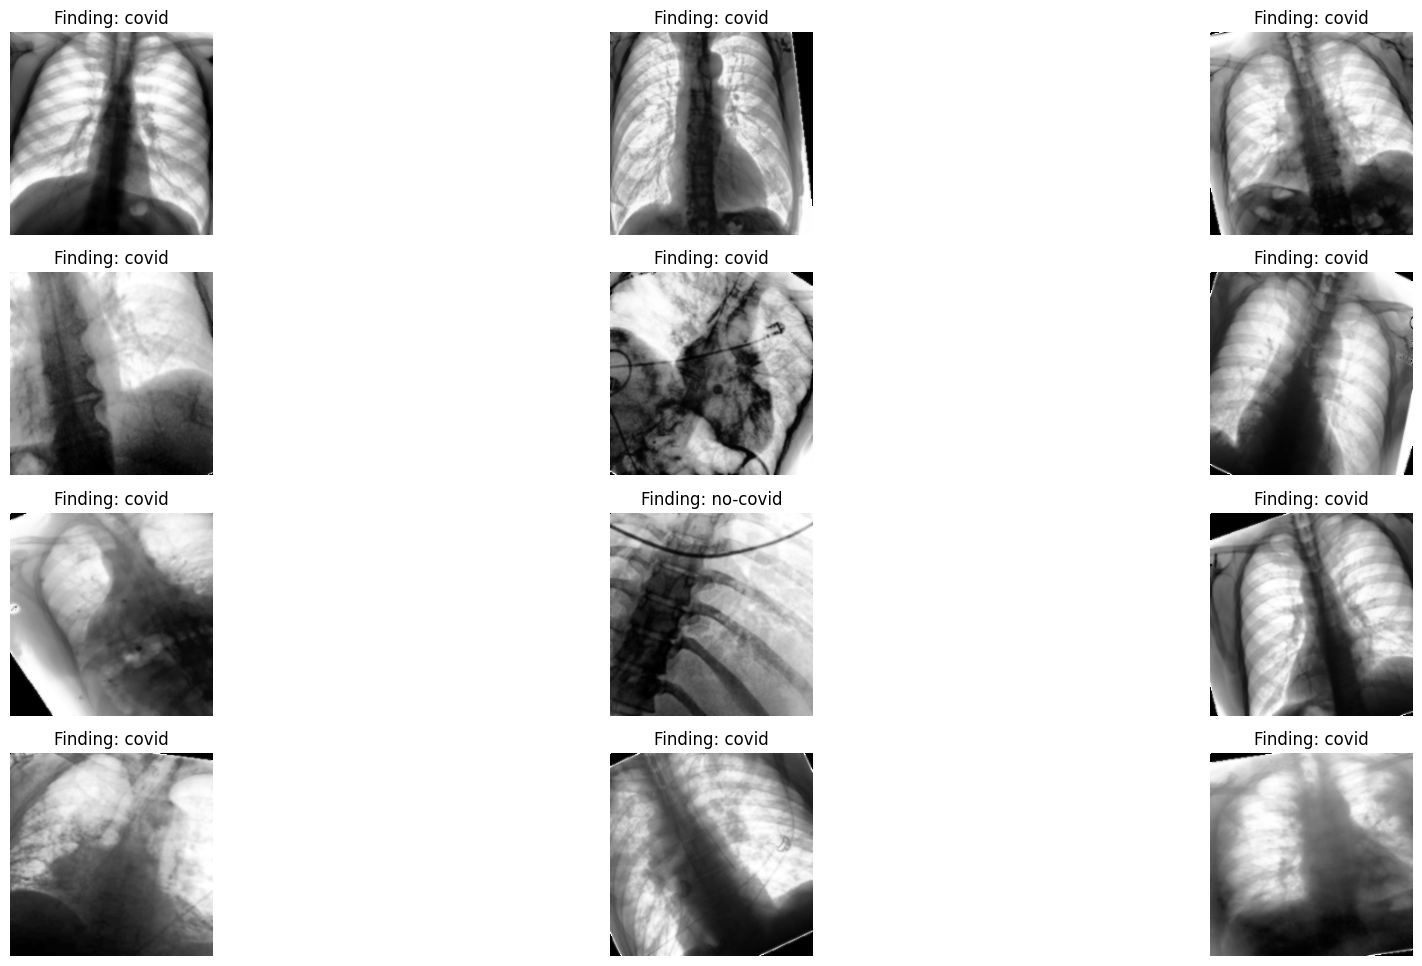

In [ ]:
Nr = 4
Nc = 3

fig, axs = plt.subplots(Nr, Nc,figsize=(20,10))
for i in range(Nr*Nc):
    sample = xray_transform[
        i + random.randrange(
            0, len(xray_transform)-(Nr*Nc)
        )]
    
    plt.subplot(Nr, Nc, i+1, aspect='auto')
    plt.tight_layout()
    plt.title('Finding: '+classes[sample['finding']])
    plt.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1, 2, 0).reshape(224,224),cmap='gray') #tensor is (ch, w, h)

plt.show()

Parallel Data Loading 

In [ ]:
image_datasets = {
    x: image_dataset(
        csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
        root_dir=covid_dataset_path,
        transform=data_transforms,
        phase=x)
    for x in ['train', 'test']
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    """
    Support function for model training.

    Args:
      model: Model to be trained
      criterion: Optimization criterion (loss)
      optimizer: Optimizer to use for training
      scheduler: Instance of ``torch.optim.lr_scheduler``
      num_epochs: Number of epochs
      device: Device to run the training on. Must be 'cpu' or 'cuda'
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs = data['image']
                labels = data['finding']
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = models.resnet18(
    pretrained=True,
    progress=True
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
num_ftrs = model.fc.in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_ftrs),
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.3)

In [ ]:
model_ft = train_model(model.to(device), criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=2, device=device)
x_ft = torch.rand(64,1, 7,7)
np.mean([timer(model,x_ft) for _ in range(10)])

Epoch 0/1
----------
train Loss: 1.4345 Acc: 0.7231
test Loss: 0.6617 Acc: 0.6974

Epoch 1/1
----------
train Loss: 1.0399 Acc: 0.5795
test Loss: 0.9337 Acc: 0.7282

Training complete in 0m 33s
Best validation Acc: 0.728205


RuntimeError: ignored

Update with Quantization and Parallel Dataloading

In [ ]:
#Quantization 

model = models.quantization.resnet18(
    
    pretrained=True,
    progress=True,
    quantize=True
)


NameError: ignored

In [ ]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = model.fc.in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, num_ftrs),
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.3)

In [ ]:
#model_ft = train_model(model.to("cuda"), criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=50, device="cuda")

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:335: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['test']:
        inputs = data['image']
        labels = data['finding']
        outputs = model_ft(inputs.float().to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network: %d %%' % (
    100 * correct / total))

Accuracy of the network: 82 %


In [ ]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))


with torch.no_grad():
    for data in dataloaders['test']:
        images = data['image']
        labels = data['finding']
        outputs = model_ft(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(images.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of no-covid : 53 %
Accuracy of covid : 93 %


In [ ]:
dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=(len(image_datasets['test'])), num_workers=8)

dataiter = iter(dataloader)
data = next(dataiter)
images = data['image']
labels = data['finding']

model_ft.to('cpu')

output = torch.tensor(model_ft(images).detach().numpy())


In [ ]:
from sklearn.metrics import classification_report
# show a nicely formatted classification report
print(classification_report(labels, np.argmax(output,1), target_names=classes))

              precision    recall  f1-score   support

    no-covid       0.76      0.54      0.63        54
       covid       0.84      0.94      0.89       141

    accuracy                           0.83       195
   macro avg       0.80      0.74      0.76       195
weighted avg       0.82      0.83      0.82       195



In [ ]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(labels, np.argmax(output,1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 29  25]
 [  9 132]]
acc: 0.8256
sensitivity: 0.5370
specificity: 0.9362
